In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM, BatchNormalization, MaxPool1D
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.layers.convolutional import Conv1D

from sklearn.preprocessing import RobustScaler
import import_ipynb
import isee_def

Using TensorFlow backend.


importing Jupyter notebook from isee_def.ipynb


In [2]:
####################################
# train 데이터 load
####################################

isee_machine = pd.read_csv('./data/isee_machine_middle_NG_inter_MapNorm_combined_label.csv')
prod_list = isee_machine.ProductNum.unique()
isee_machine = isee_machine[isee_machine.ProductNum == prod_list[0]]

###### prod_list[0] 제품에 대해서만 분석

analy_col = ['CycleTime', 'VpPosition', 'VpTime',
        'VpPressure', 'MaxInjectionPressure', 'InjectionEndPosition',
        'PlasticizingTime', 'PlasticsEndPosotion', 'ClampingTime',
        'MouldOpeningTime', 'HotOilContoller', 'TankTemp', 'NozzleTemp',
        'Zone1', 'Zone2', 'Zone3', 'Zone4'] 
isee_machine['NG_Label'] = isee_machine['NG'] + isee_machine['NG5']

In [3]:
feature = isee_machine[analy_col]
y_label = isee_machine[['combined_label','CycleNum','NG_Label']]
scaled_X = pd.DataFrame(RobustScaler().fit_transform(feature), columns=feature.columns, index=isee_machine.index)
scaled_df = pd.concat([scaled_X, y_label], axis=1)

- X: train data set 생성
- label: train data set에 해당하는 라벨(sequence의 마지막 값을 라벨로 지정)

In [ ]:
w=20    # window size
s=4     # stride
X = np.zeros((w, len(feature.columns)))
label = []
for c in scaled_df['CycleNum'].unique():
    df = scaled_df[scaled_df['CycleNum']==c]
    df = df.reset_index(drop=True)
    for i in range(int((len(df)-w)/s)):
        X = np.concatenate((X, df.loc[s*i:s*i+w-1][feature.columns].values)) 
        label.append(df.loc[s*i+w]['combined_label'])

In [ ]:
# y가 0,1,2일 때
# y = pd.get_dummies(label).values

# yy: binary로만 보고싶을때
y = [0 if x == 0 else 1 for x in label]  

In [21]:
X = X.reshape(-1,w, len(feature.columns))
X = X[1:]

In [40]:
#############################
# create the model
#############################
model = Sequential()
#model.add(Conv1D(filters= 64, kernel_size=3, padding='same', activation='relu'))
#model.add(BatchNormalization())
model.add(LSTM(100, activation = 'tanh', return_sequences= True, input_shape=(w, len(feature.columns))))
model.add(LSTM(50, activation = 'tanh'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, epochs=50, batch_size=32)

#print(model.summary())

Epoch 1/20
14157/14157 [==============================] - 22s 2ms/step - loss: 0.2650 - acc: 0.9145: 0s - loss: 0.2655 - acc: 0.91
Epoch 2/20
14157/14157 [==============================] - 17s 1ms/step - loss: 0.2358 - acc: 0.9248
Epoch 3/20
14157/14157 [==============================] - 16s 1ms/step - loss: 0.2251 - acc: 0.9289
Epoch 4/20
14157/14157 [==============================] - 19s 1ms/step - loss: 0.2222 - acc: 0.9294: 0s - loss: 0.2225 - acc:
Epoch 5/20
14157/14157 [==============================] - 20s 1ms/step - loss: 0.2171 - acc: 0.9308
Epoch 6/20
14157/14157 [==============================] - 20s 1ms/step - loss: 0.2169 - acc: 0.9303
Epoch 7/20
14157/14157 [==============================] - 20s 1ms/step - loss: 0.2118 - acc: 0.9332
Epoch 8/20
14157/14157 [==============================] - 17s 1ms/step - loss: 0.2086 - acc: 0.9341
Epoch 9/20
14157/14157 [==============================] - 16s 1ms/step - loss: 0.2068 - acc: 0.9354
Epoch 10/20
14157/14157 [==================

In [41]:
####################################
# test 데이터 load
####################################
#ori_test = pd.read_csv('./data/test_FD0001_true5.csv',encoding= 'cp949')

In [42]:
####################################
# model 평가
####################################
scores = model.evaluate(X, y)
scores

14157/14157 [==============================] - 6s 415us/step


[0.17622725329728328, 0.9451861270043088]

In [43]:
y_pre = model.predict_classes(X)
np.unique(y_pre)

array([0, 1])

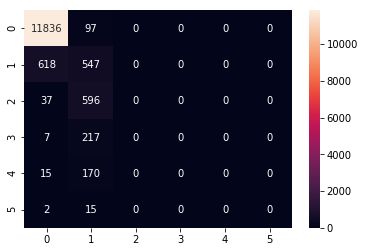

In [44]:
### plot confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

df_cm = pd.DataFrame(confusion_matrix(label, y_pre))
plt.figure()
sn.heatmap(df_cm, annot=True, fmt='d')

In [45]:
print(classification_report(label, y_pre))

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     11933
         1.0       0.33      0.47      0.39      1165
         2.0       0.00      0.00      0.00       633
         3.0       0.00      0.00      0.00       224
         4.0       0.00      0.00      0.00       185
         5.0       0.00      0.00      0.00        17

   micro avg       0.87      0.87      0.87     14157
   macro avg       0.21      0.24      0.23     14157
weighted avg       0.82      0.87      0.85     14157



C:\Users\ARA\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ARA\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ARA\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
